# Data Augmentation

one method to solve overfitting is data augmentation. Overfitting happens when the model have strong recognizion only on the training data set but fails in recognizing the data outside the training set. It can happens if the training set data size is too small compared the real life dataset. 

We can simulate real life data by augmenting the training set by applying different preprocessing techniques such as rotate, flip, shear, or zoom on existing training images so we can simulate other data that the model should also learn from. This way, the model would see more variety in the images during training so it will infer better on new, previously unseen data.

ref:
 - https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C2/W2/ungraded_labs/C2_W2_Lab_1_cats_v_dogs_augmentation.ipynb
 - https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/lecture/kiCPT/coding-augmentation-with-imagedatagenerator

In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory # 'tis a function
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-12-20 11:06:15--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.48, 172.217.1.208, 142.251.163.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   243MB/s    in 0.3s    

2022-12-20 11:06:16 (243 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [4]:
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('base dir is:', base_dir)
print('')

print('train dir is :', train_dir)
print('validation dir is :', validation_dir)

print('')
print('train cats dir is:', train_cats_dir)
print('train dogs dir is:', train_dogs_dir)

print()
print('validation cats dir:', validation_cats_dir)
print('validation dogs dir:', validation_dogs_dir)


base dir is: cats_and_dogs_filtered

train dir is : cats_and_dogs_filtered/train
validation dir is : cats_and_dogs_filtered/validation

train cats dir is: cats_and_dogs_filtered/train/cats
train dogs dir is: cats_and_dogs_filtered/train/dogs

validation cats dir: cats_and_dogs_filtered/validation/cats
validation dogs dir: cats_and_dogs_filtered/validation/dogs


## Using samplewise pixel standardization with augmentation

There are other properties on it that we can use to augment the image.

```python
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
```

These are just a few of the options available. Let's quickly go over it:

 - `rotation_range` is a value in degrees (0–180) within which to randomly rotate pictures.
 - `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
 - `shear_range` is for randomly applying shearing transformations.
 - `zoom_range` is for randomly zooming inside pictures.
 - `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
 - `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/


In [5]:
# create generator that standardize pixel values
train_datagen = ImageDataGenerator( samplewise_center=True, samplewise_std_normalization=True,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# of course we don't augment the validation dataset because it supposedly reflect outside or real life data
test_datagen  = ImageDataGenerator( samplewise_center=True, samplewise_std_normalization=True )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## model

In [6]:
def create_model():
  ## set seed so that model has same 'common ground' (it node's weight and bias are the same value on each creation)
  tf.random.set_seed(10)
  '''Creates a CNN with 4 convolutional layers'''
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model


def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()  

In [7]:
# Constant for epochs
EPOCHS = 20

train_steps_per_epoch = len(train_generator.labels)/train_generator.batch_size
validation_steps_per_epoch = len(validation_generator.labels)/validation_generator.batch_size

print('train_steps_per_epoch:', train_steps_per_epoch )

print('validation_steps_per_epoch:', validation_steps_per_epoch )

train_steps_per_epoch: 100.0
validation_steps_per_epoch: 50.0


In [8]:
# Create new model
model = create_model()
# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps_per_epoch,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=validation_steps_per_epoch,  # 1000 images = batch_size * steps
      verbose=2)


Epoch 1/20
100/100 - 26s - loss: 0.6866 - accuracy: 0.5475 - val_loss: 0.6547 - val_accuracy: 0.5870 - 26s/epoch - 264ms/step
Epoch 2/20
100/100 - 18s - loss: 0.6603 - accuracy: 0.5950 - val_loss: 0.6490 - val_accuracy: 0.6310 - 18s/epoch - 175ms/step
Epoch 3/20
100/100 - 18s - loss: 0.6489 - accuracy: 0.6180 - val_loss: 0.6165 - val_accuracy: 0.6630 - 18s/epoch - 182ms/step
Epoch 4/20
100/100 - 18s - loss: 0.6335 - accuracy: 0.6380 - val_loss: 0.6054 - val_accuracy: 0.6820 - 18s/epoch - 181ms/step
Epoch 5/20
100/100 - 18s - loss: 0.6274 - accuracy: 0.6355 - val_loss: 0.5844 - val_accuracy: 0.6870 - 18s/epoch - 181ms/step
Epoch 6/20
100/100 - 19s - loss: 0.6061 - accuracy: 0.6510 - val_loss: 0.5764 - val_accuracy: 0.6840 - 19s/epoch - 188ms/step
Epoch 7/20
100/100 - 18s - loss: 0.5862 - accuracy: 0.6875 - val_loss: 0.5660 - val_accuracy: 0.7040 - 18s/epoch - 180ms/step
Epoch 8/20
100/100 - 18s - loss: 0.5962 - accuracy: 0.6725 - val_loss: 0.5543 - val_accuracy: 0.7150 - 18s/epoch - 176

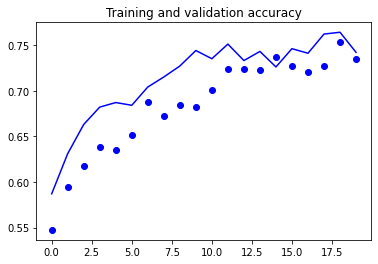

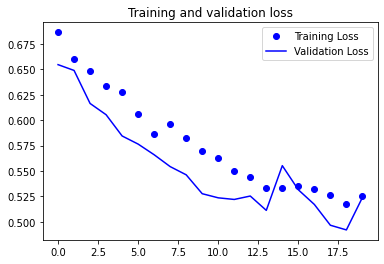

In [9]:
# Plot the results of training with data augmentation
plot_loss_acc(history)

the training accuracy has gone down compared to the baseline. This is expected because (as a result of data augmentation) there are more variety in the images so the model will need more runs to learn from them. The good thing is the validation accuracy is no longer stalling and is more in line with the training results. This means that the model is now performing better on unseen data.
